In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random 
import tensorflow as tf

# 1. SETUP: LOAD MODEL AND IMAGE
# =======================================================
print("Loading pre-trained DenseNet201 model...")
# Load the full model
model = tf.keras.applications.DenseNet201(weights='imagenet')

2025-09-02 07:49:28.417475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756799368.600740      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756799368.655474      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading pre-trained DenseNet201 model...


I0000 00:00:1756799381.307842      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishmotwani/tomato")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tomato


In [1]:
import os

# The main directory for the dataset
data_dir = '/kaggle/input/tomato/'

# List the contents (should show 'train' and 'validation' folders)
print("Dataset contents:", os.listdir(data_dir))

# You can now define your train and validation paths
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'valid')

print("\nTrain directory contents:", os.listdir(train_dir))

Dataset contents: ['valid', 'train']

Train directory contents: ['Late_blight', 'Tomato_Yellow_Leaf_Curl_Virus', 'Septoria_leaf_spot', 'Early_blight', 'Spider_mites Two-spotted_spider_mite', 'powdery_mildew', 'healthy', 'Bacterial_spot', 'Target_Spot', 'Tomato_mosaic_virus', 'Leaf_Mold']


In [3]:
import os
import random

In [4]:
train_dir = '/kaggle/input/tomato/train/'
class_folders = os.listdir(train_dir)
random_class = random.choice(class_folders)
image_files = os.listdir(os.path.join(train_dir, random_class))
random_image = random.choice(image_files)
image_path = os.path.join(train_dir, random_class, random_image)

In [7]:
# --- Preprocess the Image ---
img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
preprocessed_img = tf.keras.applications.densenet.preprocess_input(img_batch)

In [9]:
# 2. CREATE THE VISUALIZATION MODEL
# =======================================================
# We will select a few interesting layers from different depths
# Layer names can be found by running `model.summary()`
layer_names = [
    'conv1_relu',      # Corrected: The slash '/' is an underscore '_'
    'pool2_conv',      # This one was already correct
    'pool3_conv',      # This one was also correct
    'relu'             # This one was also correct
]

# Create a new model that will output the feature maps of our selected layers
layer_outputs = [model.get_layer(name).output for name in layer_names]
visualization_model = tf.keras.Model(inputs=model.inputs, outputs=layer_outputs)

# Get the feature map activations
feature_maps = visualization_model.predict(preprocessed_img)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1756799544.659246     101 service.cc:148] XLA service 0x7d4090028490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756799544.659969     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756799546.741750     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step


I0000 00:00:1756799559.495719     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


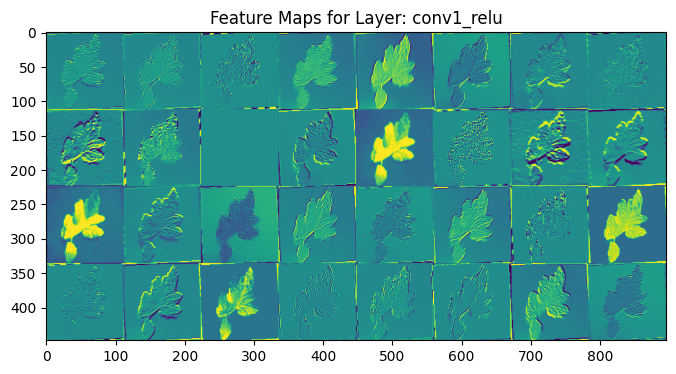

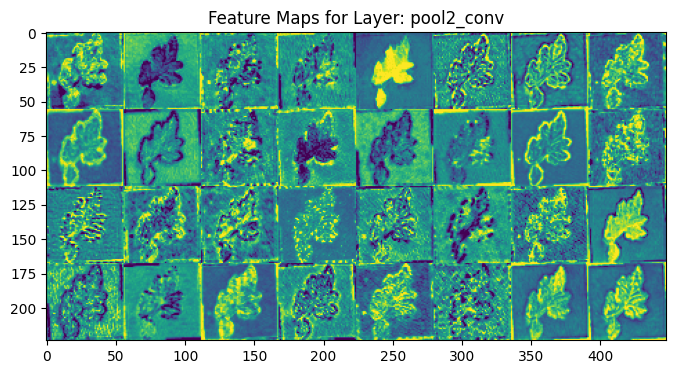

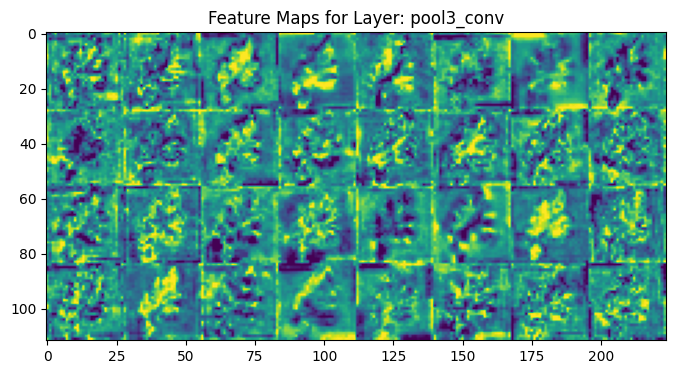

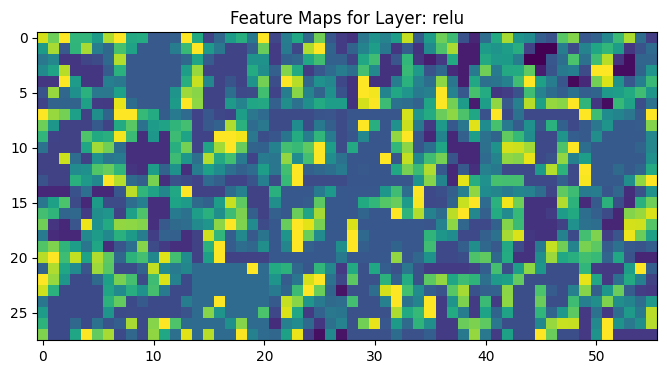

In [10]:
for layer_name, feature_map in zip(layer_names, feature_maps):
    # The feature map has shape (1, size, size, n_features)
    n_features = feature_map.shape[-1]
    size = feature_map.shape[1]

    # Set up the grid for plotting
    n_cols = 8
    n_rows = n_features // n_cols
    if n_features % n_cols > 0:
        n_rows += 1
    
    # Ensure we don't try to plot too many features
    n_rows = min(n_rows, 4) # Limit to a max of 4 rows (32 features)
    
    display_grid = np.zeros((size * n_rows, size * n_cols))
    
    # Tile the feature maps onto the grid
    for row in range(n_rows):
        for col in range(n_cols):
            feature_index = row * n_cols + col
            if feature_index < n_features:
                channel_image = feature_map[0, :, :, feature_index]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std() if channel_image.std() != 0 else 1
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[row * size : (row + 1) * size,
                             col * size : (col + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(f'Feature Maps for Layer: {layer_name}')
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()